In [1]:
import ee 
import geemap
import pandas as pd
import geopandas as gpd
import ltgee
from datetime import date
import ipyleaflet
import rioxarray as rxr

In [13]:
ee.Authenticate()

True

In [2]:
ee.Initialize(project="ee-jandrewgoldman")

In [3]:
shield = ee.FeatureCollection("users/jandrewgoldman/Ontario_Shield_v0")

In [4]:
nbac =ee.FeatureCollection("projects/sat-io/open-datasets/CA_FOREST/NBAC/nbac_1972_2023_20240530").filter(ee.Filter.eq("ADMIN_AREA", "ON")).filter(ee.Filter.gte("YEAR", 1985)) 


In [5]:
nbac_size = nbac.size().getInfo()
print(f"NBAC Ontario FeatureCollection size: {nbac_size}")


NBAC Ontario FeatureCollection size: 2805


In [6]:
# Print all properties of the first feature
first_feature = nbac.first()
print("Properties of the first feature:")
for property_name, property_value in first_feature.getInfo()['properties'].items():
    print(f"{property_name}: {property_value}")


Properties of the first feature:
ADJ_FLAG: true
ADJ_HA: 41.9652645384
ADMIN_AREA: ON
AG_EDATE: 956905200000
AG_SDATE: 956646000000
BASRC: Agency
CAPDATE: None
FIRECAUS: Human
FIREMAPM: Buffered points
FIREMAPS: Undefined
GID: 2000_529
HS_EDATE: None
HS_SDATE: None
NATPARK: 
NFIREID: 529
POLY_HA: 44.8099564591
PRESCRIBED: 
VERSION: 20240530
YEAR: 2000


In [7]:
# Clip the shield FeatureCollection to the nbac FeatureCollection
nbac_shield = nbac.filterBounds(shield.geometry())

In [26]:
nbac_shield_size = nbac_shield.size().getInfo()
print(f"NBAC Ontario Shield FeatureCollection size: {nbac_shield_size}")

NBAC Ontario Shield FeatureCollection size: 2288


In [28]:

# For a more precise clip, you can also use:
# clipped_shield = shield.map(function(feature) {
#   return feature.intersection(nbac.geometry());
# })

# Visualize the result
m = geemap.Map()
m.add_layer(nbac_shield, {}, 'Clipped Shield')
m.add_layer(nbac, {'color': 'blue'}, 'NBAC Ontario', False)
m.center_object(ee.Geometry.Point([-85, 50]), 5)  # Approximate center of Ontario
m

Map(center=[49.99999999999999, -85], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [30]:
#print the all levels of values of a property in the nbac_shield FeatureCollection
def get_unique_values(feature_collection, property_name):
    # Get the unique values of a property in a FeatureCollection
    unique_values = feature_collection.aggregate_array(property_name).getInfo()
    return set(unique_values)

# Get the unique values of the "SPECIES" property  
unique_cause = get_unique_values(nbac_shield, "FIRECAUS")
print("Unique values of the 'FIRE_CAUSE' property in the nbac_shield FeatureCollection:")
for value in unique_cause:
    print(value)

Unique values of the 'FIRE_CAUSE' property in the nbac_shield FeatureCollection:
Human
Undetermined
Natural


remove all human and undetermined

In [8]:
nbac_shield_natural = nbac_shield.filter(ee.Filter.eq("FIRECAUS", "Natural"))
nbac_shield_natural_size = nbac_shield_natural.size().getInfo()
print(f"NBAC Ontario Shield FeatureCollection size with natural fire cause: {nbac_shield_natural_size}")

NBAC Ontario Shield FeatureCollection size with natural fire cause: 1394


In [33]:
nbac_shield_undetermined  = nbac_shield.filter(ee.Filter.eq("FIRECAUS", "Undetermined"))
nbac_shield_undetermined_size = nbac_shield_undetermined.size().getInfo()
print(f"NBAC Ontario Shield FeatureCollection size with undetermined fire cause: {nbac_shield_undetermined_size}")

NBAC Ontario Shield FeatureCollection size with undetermined fire cause: 664


Remove all fires greater than 50ha

In [9]:
nbac_shield_nat_gt50 = nbac_shield_natural.filter(ee.Filter.gte("POLY_HA", 50))
nbac_shield_nat_gt50_size = nbac_shield_nat_gt50.size().getInfo()
print(f"NBAC Ontario Shield FeatureCollection size with natural fire cause and greater than 50 hectares: {nbac_shield_nat_gt50_size}")

NBAC Ontario Shield FeatureCollection size with natural fire cause and greater than 50 hectares: 1322


GET AGENCY START DATE AS YMD

In [10]:
# get AG_SDATE as date object YMD
def convert_to_date(feature):
    ag_sdate = feature.get('AG_SDATE')
    # Convert to ee.Date and format as YYYY-MM-DD
    date_object = ee.Date(ag_sdate)
    formatted_date = date_object.format('YYYY-MM-dd')
    month = date_object.get('month')
    
    # Set both the original date and formatted date as properties
    return feature.set({
        'AG_SDATE_YMD': formatted_date,
        'FIRE_MONTH': month 
    })
nbac_shield_nat_gt50 = nbac_shield_nat_gt50.map(convert_to_date)

for property_name, property_value in nbac_shield_nat_gt50.first().getInfo()['properties'].items():
    print(f"{property_name}: {property_value}")

ADJ_FLAG: true
ADJ_HA: 66.6419217477
ADMIN_AREA: ON
AG_EDATE: 1534575600000
AG_SDATE: 1531897200000
AG_SDATE_YMD: 2018-07-18
BASRC: Agency
FIRECAUS: Natural
FIREMAPM: Undefined
FIREMAPS: Undefined
FIRE_MONTH: 7
GID: 2018_1084
HS_EDATE: 1532156400000
HS_SDATE: 1532156400000
NATPARK: 
NFIREID: 1084
POLY_HA: 72.4925677237
PRESCRIBED: 
VERSION: 20240530
YEAR: 2018


In [10]:
# First filter to keep only fires with non-null AG_SDATE values
nbac_shield_nat_gt50_notnull = nbac_shield_nat_gt50.filter(
    ee.Filter.neq('AG_SDATE', None)
)

# Mask all pixels within fire that are not forested 

In [11]:
tree_species = ee.ImageCollection("projects/sat-io/open-datasets/CA_FOREST/SPECIES-1984-2022")

In [33]:
def mask_non_forested_areas(nbac_features, tree_species_collection):
    """
    Mask non-forested areas within fire perimeters using tree species data.
    
    Args:
        nbac_features: Earth Engine FeatureCollection of fire perimeters
        tree_species_collection: Earth Engine ImageCollection with tree species data
        
    Returns:
        Earth Engine FeatureCollection with additional properties for forested area
    """
    # Function to process each fire feature
    def process_fire(feature):
        # Get the year of the fire
        fire_year = ee.Number(feature.get('YEAR'))
        
        # year_before_fire 
        year_before_fire = fire_year.subtract(1)

        # Get all available image years from the tree species collection
        years = tree_species_collection.aggregate_array('system:index')
        
        # Get years by extracting last 4 characters of system:index and parsing to number
        def extract_year(index_str):
            index_str = ee.String(index_str)
            # Get the last 4 characters which should be the year
            year_str = index_str.slice(-4)
            # Try to parse as a number
            year_num = ee.Number.parse(year_str).float()
            
            # Calculate distance to year before fire
            distance = year_num.subtract(year_before_fire).abs()
            return ee.Feature(None, {
                'index': index_str, 
                'year': year_num,
                'distance': distance
            })
        
        # Map the year extraction over all indices
        year_features = ee.FeatureCollection(
            years.map(extract_year)
        )
        
        # Find the closest year
        closest_year_feature = year_features.sort('distance').first()
        
        # Get the index of the closest year
        closest_index = ee.String(closest_year_feature.get('index'))
        
        # Get the tree species image for the closest year
        tree_species_img = ee.Image(tree_species_collection.filter(
            ee.Filter.eq('system:index', closest_index)
        ).first())
        
        # Create a binary mask where tree species > 0 (forested areas)
        forest_mask = tree_species_img.gt(0)
        
        # Clip to the fire perimeter
        fire_geom = feature.geometry()
        clipped_mask = forest_mask.clip(fire_geom)
        
        # Calculate forested area (in hectares)
        pixel_area = ee.Image.pixelArea().divide(10000)  # Convert to hectares
        forested_area = clipped_mask.multiply(pixel_area).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=fire_geom,
            scale=30,  # Assuming 30m resolution
            maxPixels=1e9
        ).get('b1')
        
        # Default to 0 if forested_area is null (using dummy operation to check for null)
        forested_area = ee.Number(ee.Algorithms.If(
            forested_area,  # This will be falsy if null
            forested_area,
            0
        ))
        
        # Calculate the percentage of forested area
        total_area = ee.Number(feature.get('POLY_HA'))
        forested_percent = forested_area.divide(total_area).multiply(100)
        
        # Add properties to the feature
        return feature.set({
            'forested_area_ha': forested_area,
            'forested_percent': forested_percent,
            'tree_species_year': closest_year_feature.get('year'),
            'tree_species_index': closest_index
        })
    
    # Map the function over the FeatureCollection
    return nbac_features.map(process_fire)

In [34]:
# Apply the mask to remove non-forested areas from fires
nbac_shield_nat_gt50_forested = mask_non_forested_areas(nbac_shield_nat_gt50_notnull, tree_species)

# Let's examine the result
first_masked_feature = nbac_shield_nat_gt50_forested.first()
print("Properties of the first masked feature:")
for property_name, property_value in first_masked_feature.getInfo()['properties'].items():
    print(f"{property_name}: {property_value}")

# Filter out fires with low forest cover (e.g., less than 50% forested)
nbac_shield_nat_gt50_mostly_forested = nbac_shield_nat_gt50_forested.filter(
    ee.Filter.gt('forested_percent', 50)
)

# Get the count of fires before and after filtering
before_count = nbac_shield_nat_gt50_forested.size().getInfo()
after_count = nbac_shield_nat_gt50_mostly_forested.size().getInfo()

print(f"Fires before filtering for forest cover: {before_count}")
print(f"Fires with >50% forested area: {after_count}")
print(f"Removed {before_count - after_count} fires with insufficient forest cover")

Properties of the first masked feature:
ADJ_FLAG: true
ADJ_HA: 66.6419217477
ADMIN_AREA: ON
AG_EDATE: 1534575600000
AG_SDATE: 1531897200000
BASRC: Agency
FIRECAUS: Natural
FIREMAPM: Undefined
FIREMAPS: Undefined
GID: 2018_1084
HS_EDATE: 1532156400000
HS_SDATE: 1532156400000
NATPARK: 
NFIREID: 1084
POLY_HA: 72.4925677237
PRESCRIBED: 
VERSION: 20240530
YEAR: 2018
forested_area_ha: 63.41448836813536
forested_percent: 87.4772274722492
tree_species_index: Canada_Tree_Species_Classification_HMM_2017
tree_species_year: 2017
Fires before filtering for forest cover: 1320
Fires with >50% forested area: 1263
Removed 57 fires with insufficient forest cover


filter fires 1990 -2021

In [36]:
# filter out years before 1990
nbac_shield_nat_gt50_mostly_forested_1990 = nbac_shield_nat_gt50_mostly_forested.filter(
    ee.Filter.gte('YEAR', 1990)
)
# Get the count of fires after filtering for years >= 1990
after_count_1990 = nbac_shield_nat_gt50_mostly_forested_1990.size().getInfo()
print(f"Fires with >50% forested area and year >= 1990: {after_count_1990}")

Fires with >50% forested area and year >= 1990: 1078


split into 1990-2000, 2001-2010, 2011-2021

In [39]:
# 1990-2000
nbac_shield_nat_gt50_mostly_forested_1990_2000 = nbac_shield_nat_gt50_mostly_forested_1990.filter(
    ee.Filter.rangeContains('YEAR', 1990, 2000)
)
# Get the count of fires in the 1990-2000 range
after_count_1990_2000 = nbac_shield_nat_gt50_mostly_forested_1990_2000.size().getInfo()
print(f"Fires with >50% forested area between 1990 and 2000: {after_count_1990_2000}")
# 2001-2010
nbac_shield_nat_gt50_mostly_forested_2001_2010 = nbac_shield_nat_gt50_mostly_forested_1990.filter(
    ee.Filter.rangeContains('YEAR', 2001, 2010)
)
# Get the count of fires in the 2001-2010 range
after_count_2001_2010 = nbac_shield_nat_gt50_mostly_forested_2001_2010.size().getInfo()
print(f"Fires with >50% forested area between 2001 and 2010: {after_count_2001_2010}")
# 2011-2021     
nbac_shield_nat_gt50_mostly_forested_2011_2021 = nbac_shield_nat_gt50_mostly_forested_1990.filter(
    ee.Filter.rangeContains('YEAR', 2011, 2021)
)
# Get the count of fires in the 2011-2021 range
after_count_2011_2021 = nbac_shield_nat_gt50_mostly_forested_2011_2021.size().getInfo()
print(f"Fires with >50% forested area between 2011 and 2021: {after_count_2011_2021}")

Fires with >50% forested area between 1990 and 2000: 379
Fires with >50% forested area between 2001 and 2010: 235
Fires with >50% forested area between 2011 and 2021: 411


Export to geodataframe

In [ ]:
def ee_fc_to_gdf(fc):
    """
    Convert an Earth Engine FeatureCollection to a GeoPandas DataFrame
    
    Args:
        fc: Earth Engine FeatureCollection
    
    Returns:
        GeoPandas DataFrame
    """
    # Get the feature collection as a list of features
    features = fc.getInfo()['features']
    
    # Create a list to store properties
    properties = []
    
    # Extract properties and prepare geometries from each feature
    for feature in features:
        props = feature['properties'].copy()
        
        # Add geometry to properties (will be converted by gpd.read_file)
        props['geometry'] = feature['geometry']
        
        # Convert ee.Date objects to strings if they exist
        for key, value in props.items():
            if isinstance(value, dict) and 'type' in value and value['type'] == 'Date':
                props[key] = ee.Date(value).format('YYYY-MM-dd').getInfo()
        
        properties.append(props)
    
    # Create a GeoDataFrame from the list of features
    import json
    features_json = {"type": "FeatureCollection", "features": [
        {"type": "Feature", "properties": {k: v for k, v in props.items() if k != 'geometry'}, 
         "geometry": props['geometry']} 
        for props in properties
    ]}
    
    # Write to a temporary file and read with GeoPandas
    with open('temp_features.geojson', 'w') as f:
        json.dump(features_json, f)
    
    gdf = gpd.read_file('temp_features.geojson')
    
    # Set CRS to EPSG:4326 (WGS84) - Earth Engine's default
    gdf.crs = "EPSG:4326"
    
    return gdf

In [35]:
# Filter for fires > 50ha
nbac_shield_nat_gt50_gdf = ee_fc_to_gdf(nbac_shield_nat_gt50_notnull)
print(f"Natural fires > 50ha: {len(nbac_shield_nat_gt50_gdf)}")

Natural fires > 50ha: 1320


In [37]:
# Save as GeoJSON which supports mixed geometry types
nbac_shield_nat_gt50_gdf.to_file("../data/nbac_shield_natural_gt50.geojson", driver="GeoJSON")

In [41]:
# convert the FeatureCollection to a GeoDataFrame 1990-2000
nbac_shield_nat_gt50_mostly_forested_gdf_1990_2000 = ee_fc_to_gdf(nbac_shield_nat_gt50_mostly_forested_1990_2000)
# convert the FeatureCollection to a GeoDataFrame 2001-2010
nbac_shield_nat_gt50_mostly_forested_gdf_2001_2010 = ee_fc_to_gdf(nbac_shield_nat_gt50_mostly_forested_2001_2010)
# convert the FeatureCollection to a GeoDataFrame : 2011-2021
nbac_shield_nat_gt50_mostly_forested_gdf_2011_2021 = ee_fc_to_gdf(nbac_shield_nat_gt50_mostly_forested_2011_2021)


In [42]:
#save as GeoJSON which supports mixed geometry types
nbac_shield_nat_gt50_mostly_forested_gdf_1990_2000.to_file("../data/nbac_shield_natural_gt50_mostly_forested_1990_2000.geojson", driver="GeoJSON")
nbac_shield_nat_gt50_mostly_forested_gdf_2001_2010.to_file("../data/nbac_shield_natural_gt50_mostly_forested_2001_2010.geojson", driver="GeoJSON")
nbac_shield_nat_gt50_mostly_forested_gdf_2011_2021.to_file("../data/nbac_shield_natural_gt50_mostly_forested_2011_2021.geojson", driver="GeoJSON")

Visualize the number of fires per year in bar chart

In [38]:
nbac_shield_nat_gt50_gdf.columns

Index(['ADJ_FLAG', 'ADJ_HA', 'ADMIN_AREA', 'AG_EDATE', 'AG_SDATE',
       'AG_SDATE_YMD', 'BASRC', 'CAPDATE', 'FIRECAUS', 'FIREMAPM', 'FIREMAPS',
       'FIRE_MONTH', 'GID', 'HS_EDATE', 'HS_SDATE', 'NATPARK', 'NFIREID',
       'POLY_HA', 'PRESCRIBED', 'VERSION', 'YEAR', 'geometry'],
      dtype='object')

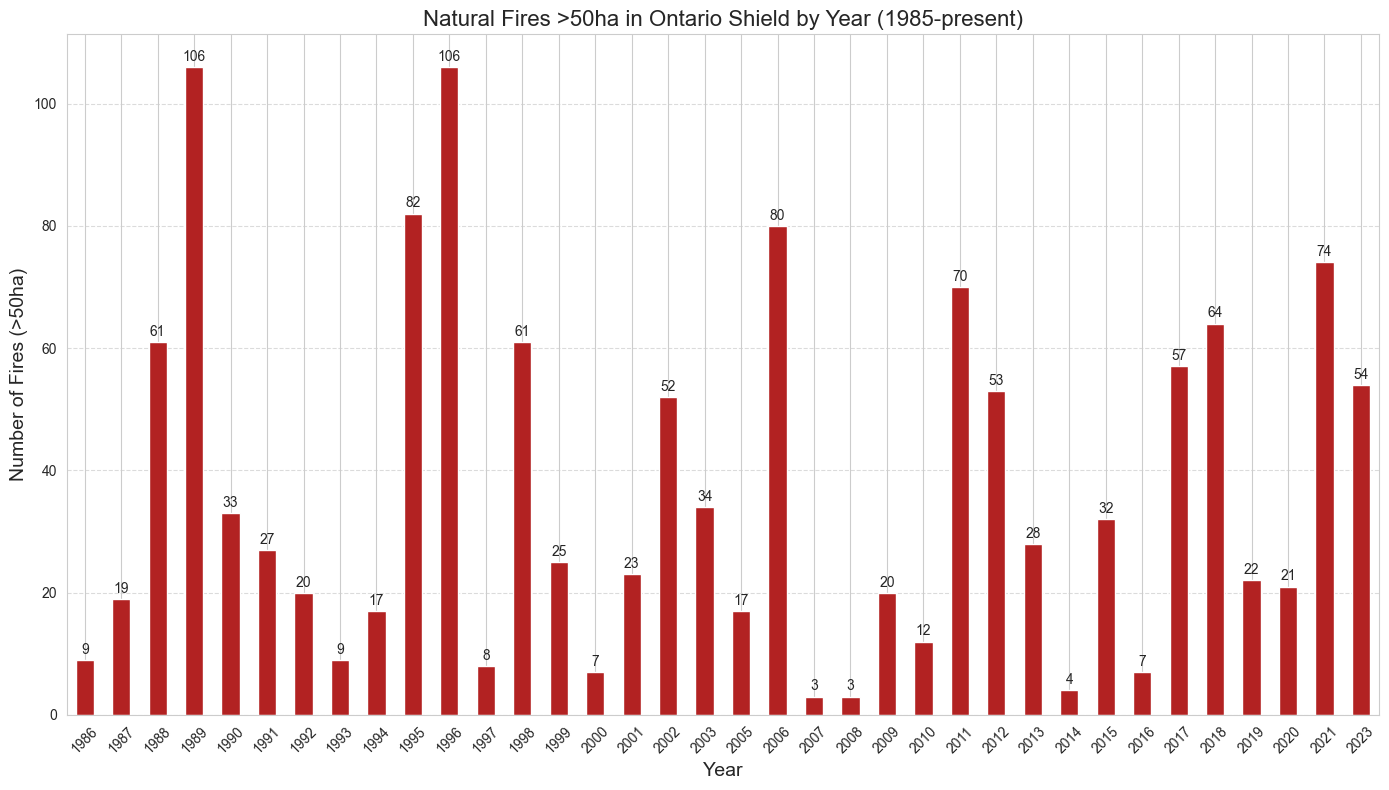

Total number of fires: 1320
Year with most fires: 1989 (106 fires)
Year with fewest fires: 2007 (3 fires)
Average fires per year: 36.7


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# Count fires by year
fires_per_year = nbac_shield_nat_gt50_gdf['YEAR'].value_counts().sort_index()

# Create the bar chart
ax = fires_per_year.plot(kind='bar', color='firebrick')

# Add labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Fires (>50ha)', fontsize=14)
plt.title('Natural Fires >50ha in Ontario Shield by Year (1985-present)', fontsize=16)

# Add data labels on top of each bar
for i, v in enumerate(fires_per_year):
    ax.text(i, v + 1, str(v), ha='center', fontsize=10)

# Improve x-axis labels
plt.xticks(rotation=45)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print(f"Total number of fires: {len(nbac_shield_nat_gt50_gdf)}")
print(f"Year with most fires: {fires_per_year.idxmax()} ({fires_per_year.max()} fires)")
print(f"Year with fewest fires: {fires_per_year.idxmin()} ({fires_per_year.min()} fires)")
print(f"Average fires per year: {fires_per_year.mean():.1f}")

How many fires from 2000-2021 and 2011-2021

<Figure size 1600x1000 with 0 Axes>

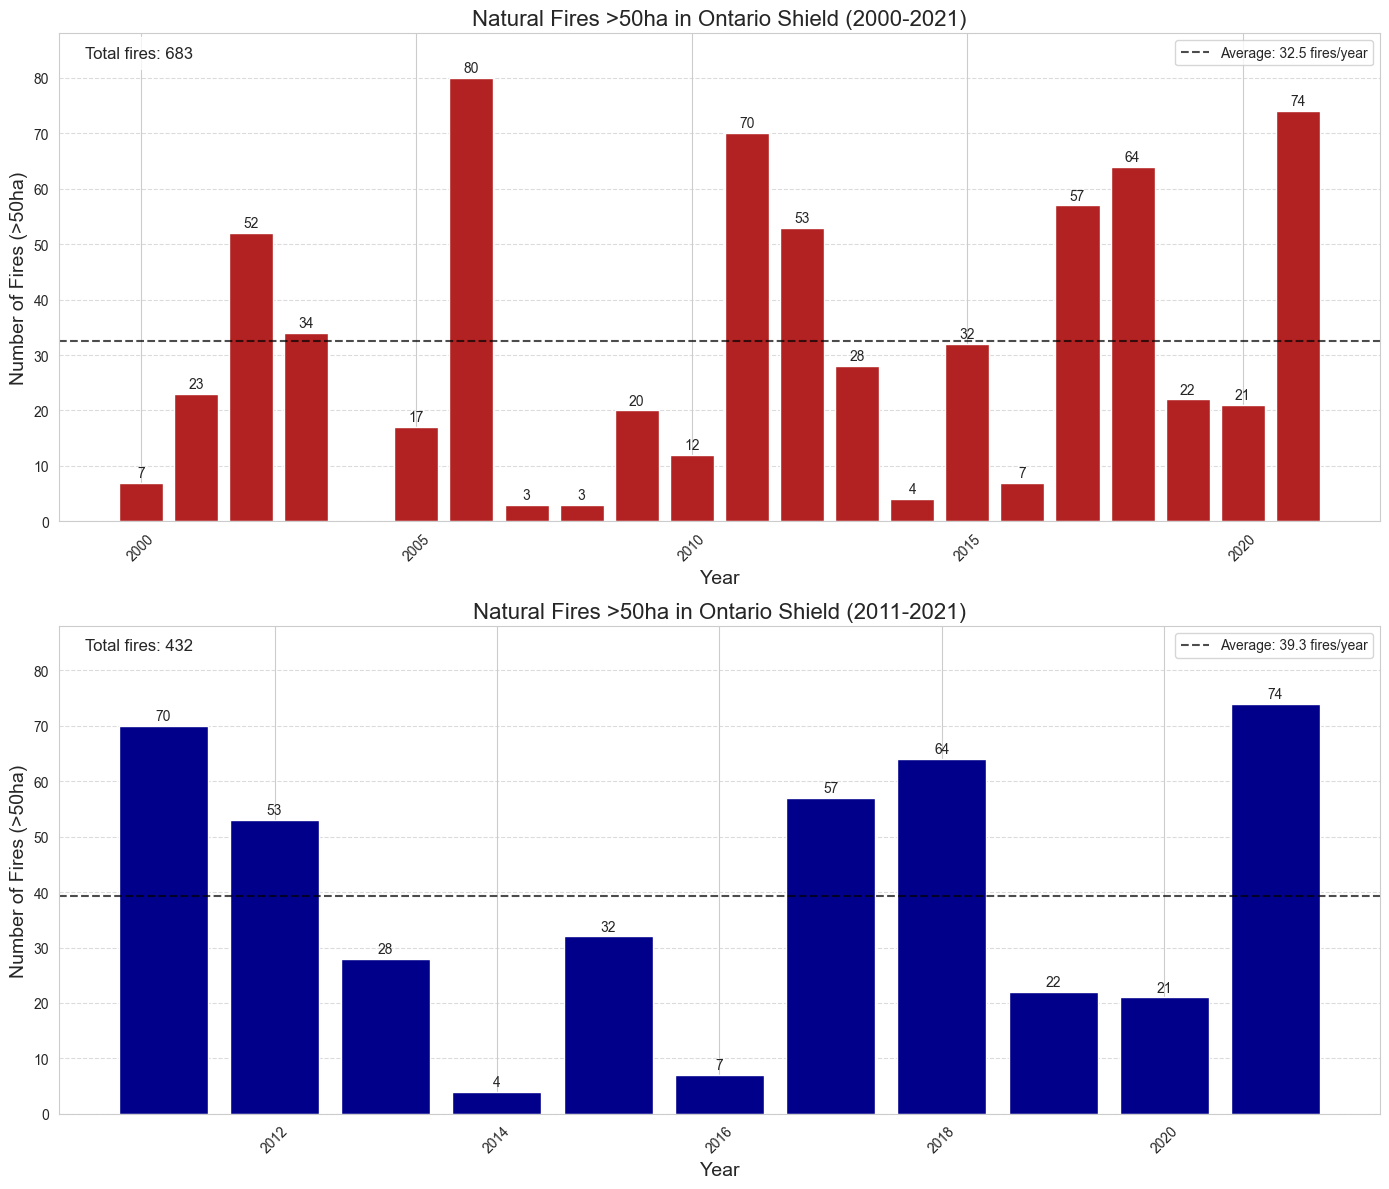

2000-2021 Period:
  Total number of fires: 683
  Year with most fires: 2006 (80 fires)
  Year with fewest fires: 2007 (3 fires)
  Average fires per year: 32.5

2011-2021 Period:
  Total number of fires: 432
  Year with most fires: 2021 (74 fires)
  Year with fewest fires: 2014 (4 fires)
  Average fires per year: 39.3

Comparison:
  Percentage of 2000-2021 fires occurring in 2011-2021: 63.3%


In [41]:


# Set the style for the plots
sns.set_style("whitegrid")
plt.figure(figsize=(16, 10))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Filter data for each time period
fires_2000_2021 = nbac_shield_nat_gt50_gdf[
    (nbac_shield_nat_gt50_gdf['YEAR'] >= 2000) & 
    (nbac_shield_nat_gt50_gdf['YEAR'] <= 2021)
]

fires_2011_2021 = nbac_shield_nat_gt50_gdf[
    (nbac_shield_nat_gt50_gdf['YEAR'] >= 2011) & 
    (nbac_shield_nat_gt50_gdf['YEAR'] <= 2021)
]

# Count fires by year for each period
fires_per_year_2000_2021 = fires_2000_2021['YEAR'].value_counts().sort_index()
fires_per_year_2011_2021 = fires_2011_2021['YEAR'].value_counts().sort_index()

# Plot 2000-2021 data
bars1 = ax1.bar(fires_per_year_2000_2021.index, fires_per_year_2000_2021.values, color='firebrick')
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Number of Fires (>50ha)', fontsize=14)
ax1.set_title('Natural Fires >50ha in Ontario Shield (2000-2021)', fontsize=16)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of each bar for 2000-2021
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Add average line for 2000-2021
avg_2000_2021 = fires_per_year_2000_2021.mean()
ax1.axhline(y=avg_2000_2021, color='black', linestyle='--', alpha=0.7, 
           label=f'Average: {avg_2000_2021:.1f} fires/year')

# Add total fires text for 2000-2021
total_fires_2000_2021 = len(fires_2000_2021)
ax1.text(0.02, 0.95, f'Total fires: {total_fires_2000_2021}', 
        transform=ax1.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

# Plot 2011-2021 data
bars2 = ax2.bar(fires_per_year_2011_2021.index, fires_per_year_2011_2021.values, color='darkblue')
ax2.set_xlabel('Year', fontsize=14)
ax2.set_ylabel('Number of Fires (>50ha)', fontsize=14)
ax2.set_title('Natural Fires >50ha in Ontario Shield (2011-2021)', fontsize=16)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of each bar for 2011-2021
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Add average line for 2011-2021
avg_2011_2021 = fires_per_year_2011_2021.mean()
ax2.axhline(y=avg_2011_2021, color='black', linestyle='--', alpha=0.7,
           label=f'Average: {avg_2011_2021:.1f} fires/year')

# Add total fires text for 2011-2021
total_fires_2011_2021 = len(fires_2011_2021)
ax2.text(0.02, 0.95, f'Total fires: {total_fires_2011_2021}', 
        transform=ax2.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

# Add legends
ax1.legend()
ax2.legend()

# Ensure the y-axis limits are consistent for better comparison
max_fires = max(fires_per_year_2000_2021.max(), fires_per_year_2011_2021.max())
ax1.set_ylim(0, max_fires * 1.1)  # Add 10% padding
ax2.set_ylim(0, max_fires * 1.1)

# Adjust layout and show
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"2000-2021 Period:")
print(f"  Total number of fires: {total_fires_2000_2021}")
print(f"  Year with most fires: {fires_per_year_2000_2021.idxmax()} ({fires_per_year_2000_2021.max()} fires)")
print(f"  Year with fewest fires: {fires_per_year_2000_2021.idxmin()} ({fires_per_year_2000_2021.min()} fires)")
print(f"  Average fires per year: {avg_2000_2021:.1f}")

print(f"\n2011-2021 Period:")
print(f"  Total number of fires: {total_fires_2011_2021}")
print(f"  Year with most fires: {fires_per_year_2011_2021.idxmax()} ({fires_per_year_2011_2021.max()} fires)")
print(f"  Year with fewest fires: {fires_per_year_2011_2021.idxmin()} ({fires_per_year_2011_2021.min()} fires)")
print(f"  Average fires per year: {avg_2011_2021:.1f}")

print(f"\nComparison:")
print(f"  Percentage of 2000-2021 fires occurring in 2011-2021: {(total_fires_2011_2021/total_fires_2000_2021)*100:.1f}%")